In [2]:
import pygsp as p
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import cv2

In [3]:
paths = ["imgs/im_proc/cameraman.jpg",
         "imgs/im_proc/pikachu.png",
         "imgs/im_proc/small_pikachu.png",
         "imgs/im_proc/not_a_real_human.jpg"]

In [4]:
def setup(path):
    
    image = np.flip(cv2.imread(path), axis = -1)/255
    sizex, sizey = np.shape(image)[:2]
    image_flatten = image.reshape(sizex * sizey, 3).T
    
    return image, image_flatten, (sizex, sizey)

def crop(image, x, y, t):
    
    crop_image = image[y : y + t, x : x + t]
    crop_image_flatten = crop_image.reshape(t * t, 3).T
    
    return crop_image, crop_image_flatten

def make_noisy_image(path, mu = 0, sigma = 0.1):
    
    image, image_flatten, sizes = setup(path)
    sizex, sizey = np.shape(image)[:2]
    
    r_noisy = image_flatten[0] + np.random.normal(mu, sigma, size = len(image_flatten[0]))
    b_noisy = image_flatten[1] + np.random.normal(mu, sigma, size = len(image_flatten[2])) ## indices trocados para converter rgb em rbg
    g_noisy = image_flatten[2] + np.random.normal(mu, sigma, size = len(image_flatten[1])) ## indices trocados para converter rgb em rbg
    
    noises = np.array([r_noisy, b_noisy, g_noisy])
    image_noisy = noises.T.reshape(sizex, sizey, 3)
    
    return image_noisy, noises

In [5]:
# i, x, y, t = 0, 92, 30, 80
i, x, y, t = 3, 60, 40, 150
mu, sigma = 0, 0.1

image, image_flatten, (sizex, sizey) = setup(paths[i])
crop_image, crop_image_flatten = crop(image, x, y, t)

image_noisy, noises = make_noisy_image(paths[i], mu, sigma)
crop_image_noisy, crop_image_noisy_flatten = crop(image_noisy, x, y, t)

In [6]:
def h(x, tau = 0.25):
    return 1. / (1. + tau * x)

def denoise_signal(G, tau, image_noisy):

    G.estimate_lmax()
    f = lambda x: h(x, tau)
    g = p.filters.Filter(G, f)
    
    sizex, sizey = np.shape(image_noisy)[:2]
    noises = image_noisy.reshape(sizex * sizey, 3).T
    r_denoised, g_denoised, b_denoised = g.filter(noises[0]), g.filter(noises[1]), g.filter(noises[2])
    image_denoised = np.array([r_denoised, g_denoised, b_denoised]).T.reshape(sizex, sizey, 3)
    
    return image_denoised

def generate_grid(image):
    
    sizex, sizey = np.shape(image)[:2]
    xs = np.linspace(0, 1, sizex)
    ys = np.linspace(0, 1, sizey)
    # full coorindate arrays
    data = np.rot90(np.array(np.meshgrid(ys, xs)).T, k = 1)
    data = data.reshape(sizex * sizey, 2)
    return data

In [7]:
data = generate_grid(image)
eps = np.sqrt((1 / sizex) ** 2 + (1 / sizey) ** 2) + 1e-4
# eps = 1/sizex * np.sqrt(2) + 1e-3
# eps = 0.02301448

G = p.graphs.Grid2d(sizex, sizey)

L = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps, center = False, rescale = False)

In [8]:
G.Ne, L.Ne

(130560, 260610)

In [9]:
d = np.linalg.norm(image_noisy[0][0] - image_noisy[1][1])
np.exp(-d ** 2/(2 * 0.1 ** 2)), d

(0.18179741994861576, 0.18465439550908316)

In [11]:
#contas feitas com sizex = sizey
image_noisy_flatten = image_noisy.reshape(sizex * sizey, 3)
for i in range(sizex * sizey):
    
    #diretamente acima #mudar sizex e sizey onde precisar
    if i >= sizex:
        d = np.linalg.norm(image_noisy_flatten[i] - image_noisy_flatten[i - sizex])
        L.W[i - sizex, i] = np.exp(-(d ** 2)/(2 * sigma ** 2))
        L.W[i, i - sizex] = np.exp(-(d ** 2)/(2 * sigma ** 2))
    
    #diagonal superior #mudar sizex e sizey onde precisar
    if i > sizex and i %sizex != sizex - 1:
        d = np.linalg.norm(image_noisy_flatten[i] - image_noisy_flatten[i - sizex + 1])
        L.W[i - sizex + 1, i] = np.exp(-(d ** 2)/(2 * sigma ** 2))
        L.W[i, i - sizex + 1] = np.exp(-(d ** 2)/(2 * sigma ** 2))
    
    #diretamente do lado direito #mudar sizex e sizey onde precisar
    if i % sizex != sizex - 1:
        d = np.linalg.norm(image_noisy_flatten[i] - image_noisy_flatten[i + 1])
        L.W[i + 1, i] = np.exp(-(d ** 2)/(2 * sigma ** 2))
        L.W[i, i + 1] = np.exp(-(d ** 2)/(2 * sigma ** 2))
        
    #diagonal inferior #mudar sizex e sizey onde precisar
    if (sizex * sizey) - (i + sizex) > 0 and i % sizex != sizex - 1:
        d = np.linalg.norm(image_noisy_flatten[i] - image_noisy_flatten[i + sizex + 1])
        L.W[i + sizex + 1, i] = np.exp(-(d ** 2)/(2 * sigma ** 2))
        L.W[i, i + sizex + 1] = np.exp(-(d ** 2)/(2 * sigma ** 2))
    
    #diretamente abaixo #mudar sizex e sizey onde precisar
    if (sizex * sizey) - (i + sizex) > 0:
        d = np.linalg.norm(image_noisy_flatten[i] - image_noisy_flatten[i + sizex])
        L.W[i + sizex, i] = np.exp(-(d ** 2)/(2 * sigma ** 2))
        L.W[i, i + sizex] = np.exp(-(d ** 2)/(2 * sigma ** 2))

In [12]:
G.W[0,256], G.W[0,257], L.W[0,256], L.W[0,257] #G nao tem diagonais, mas L tem

(1.0, 0.0, 0.0598510487218199, 0.18179741994861576)

In [13]:
G.N, L.N, G.Ne, L.Ne

(65536, 65536, 130560, 260610)

In [36]:
tau = 1#0.25 for cameraman
G_image_denoised = denoise_signal(G, tau, image_noisy)
G_crop_image_denoised, G_crop_image_denoised_flatten = crop(G_image_denoised, x, y, t)

L_image_denoised = denoise_signal(L, tau, image_noisy)
L_crop_image_denoised, L_crop_image_denoised_flatten = crop(L_image_denoised, x, y, t)

In [37]:
titles = [['original image', 'noisy image', 'cropped noisy image'], ['original image', 'denoised image (grid)', 'cropped denoised image (grid)'], ['original image', 'cropped denoised image (grid diagonals)', 'cropped denoised image (grid diagonals)']]

imgs = [[image, image_noisy, crop_image_noisy],
        [image, G_image_denoised, G_crop_image_denoised],
        [image, L_image_denoised, L_crop_image_denoised], 
        ]

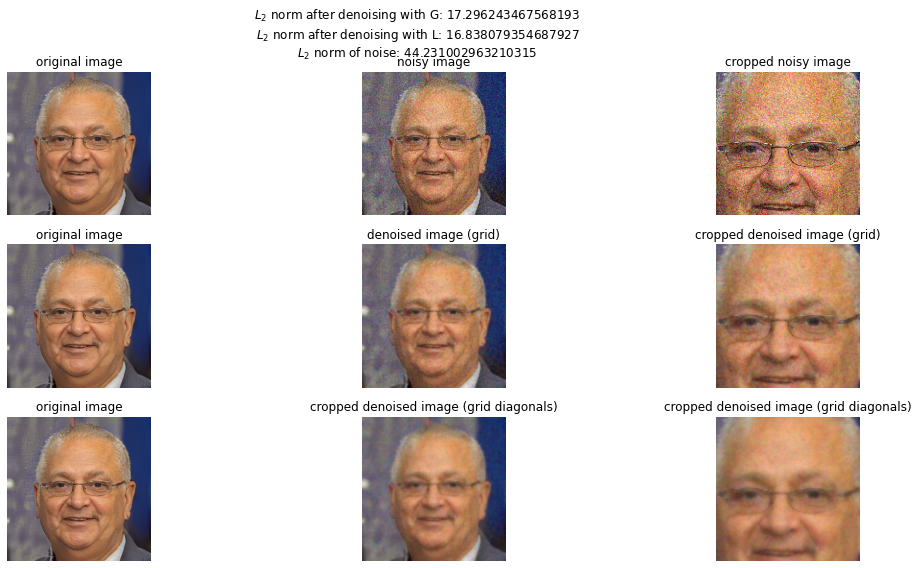

In [38]:
fig, ax = plt.subplots(3, 3, figsize = (18, 9))

for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        ax[i][j].imshow(np.clip(imgs[i][j], 0, 1))
        ax[i][j].axis('off')
        ax[i][j].set_title(titles[i][j])
fig.suptitle(r'$L_2$ norm after denoising with G: ' + str(np.linalg.norm(image - G_image_denoised)) + 
            '\n' + r'$L_2$ norm after denoising with L: ' +  str(np.linalg.norm(image - L_image_denoised)) + 
            '\n' + r'$L_2$ norm of noise: ' + str(np.linalg.norm(image - image_noisy)))
plt.show()

# Comparando diferenças entre imagens

In [39]:
# np.array([image.reshape(sizex * sizey, 3).T[0] - L_image_denoised.reshape(sizex * sizey, 3).T[0],
#  image.reshape(sizex * sizey, 3).T[1] - L_image_denoised.reshape(sizex * sizey, 3).T[1],
#  image.reshape(sizex * sizey, 3).T[2] - L_image_denoised.reshape(sizex * sizey, 3).T[2]]).reshape(sizex, sizey, 3)

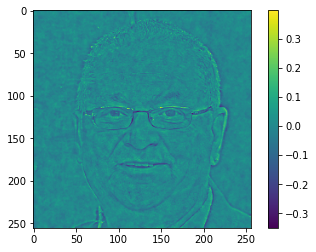

In [40]:
plt.imshow(image.reshape(sizex * sizey, 3).T[0].reshape(sizex, sizey) - L_image_denoised.reshape(sizex * sizey, 3).T[0].reshape(sizex, sizey))
plt.colorbar()
plt.show()

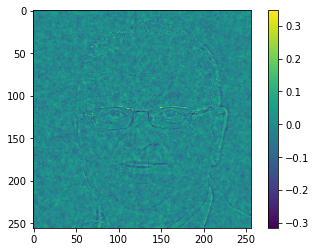

In [41]:
plt.imshow(image.reshape(sizex * sizey, 3).T[0].reshape(sizex, sizey) - G_image_denoised.reshape(sizex * sizey, 3).T[0].reshape(sizex, sizey))
plt.colorbar()
plt.show()

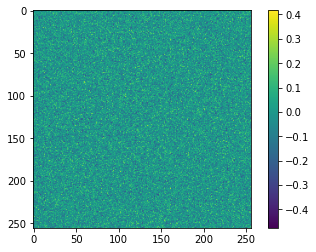

In [42]:
plt.imshow(image.reshape(sizex * sizey, 3).T[0].reshape(sizex, sizey) - image_noisy.reshape(sizex * sizey, 3).T[0].reshape(sizex, sizey))
plt.colorbar()
plt.show()

In [23]:
# for i, eps in enumerate(np.arange(1.1/sizey, 0.2, 0.5/sizey)):
# # for i, eps in enumerate([1/sizey + 1e-3, 1/sizex + 1e-3, np.sqrt((1/sizey) ** 2 + (1/sizex) ** 2) + 1e-7]):
#     print(i, eps)
#     L = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps, center = False, rescale = False)
#     L.estimate_lmax()
#     l = p.filters.Filter(L, h)
#     denoised_gray_signal = l.filter(noisy_gray_signal)
#     plt.ion()
#     fig, ax = plt.subplots(1, 3, figsize=(15,5))
#     ax[0].imshow(gray_signal.reshape(sizex, sizey))
#     ax[1].imshow(noisy_gray_signal.reshape(sizex, sizey))
#     ax[2].imshow(denoised_gray_signal.reshape(sizex, sizey))
#     titles = ['original gray image', 'noisy image', 'filtered image' + '\n' 'graph has ' + str(L.Ne) + ' edges' + '\n' 'max difference between denoised signal and original signal is ' + str(np.linalg.norm(denoised_gray_signal - gray_signal))]
#     for j in [0,1,2]:
#         ax[j].axis('off')
#         ax[j].set_title(titles[j])
#     plt.savefig("imgs/test2/" + str(i) )
#     plt.close(fig)